In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

plt.rcParams.update({"font.size": 8})

# Conditional Density Estimation

Typically, when we seek to model the relationship between a target variable $Y\in\mathbb{R}$ and one or more covariates $X$, our goal is to establish a conditional-expectation type association. Mathematically, if we define our loss as the mean squared error, our explicit aim is to identify the function $\mathbb{E} \left( Y \,|\, X=x\right)$. This function intuitively gives a prediction of the average value of $Y$ given that the covariates are $X=x$. Despite the straightforward and simplified summary provided by point estimates, they often fail to encapsulate the inherent intricacies and uncertainties prevalent in most real-world predictive scenarios. This prompts us to ask: Is the variance around this average value extensive, or can we confidently anticipate the value to be in close proximity to the predicted one?

Diverging from the conventional approach of a single point estimation, Conditional Density Estimation (CDE) aims to understand the plausibility of an entire range of potential outcomes given specific input data. In mathematical terms, we're estimating the probability density function $f \left( y \,|\, X=x \right)$.

The holistic nature of CDE affords a deeper understanding of data characteristics and proves beneficial in addressing two fundamental aspects: evaluating model trustworthiness outcomes and accommodating multi-modal.

1. **Model Trustworthiness:** Unlike point estimation predictions, which offer no insight into their own reliability or uncertainty, CDE provides a full distribution of potential outcomes, thereby inherently conveying information about prediction confidence. The varaince of the predicted distribution can act as a measure of uncertainty or confidence, affording users a more comprehensive understanding of the predictions. Such an understanding proves critical when making decisions based on these predictions. For instance, in the healthcare sector, a prediction about patient outcomes accompanied by an understanding of its confidence or uncertainty could lead to more informed and suitable medical decisions.

2. **Multi-modal outcomes:** Traditional regression or classification problems, generally focused on single point predictions, often fall short in capturing the full complexity of real-world phenomena. This shortfall becomes particularly apparent when a single input could feasibly yield multiple valid outputs, a situation termed as multi-modality. Consider a task of predicting salary based on certain features, but we're unsure if the individual resides in a state with a high or low average salary. In such a context, a more nuanced salary estimate shouldn't merely be an average drawn from both regions. Rather, it would be more fitting to present a bi-modal distribution with two distinct peaks. Each peak would denote a plausible salary range for the individual, depending on whether they live in one state or another.

$\oint$ _The field of conformal predictions aims to address this uncertainty by estimating confidence intervals $IC(X=x)$ around the model's predictions, such that $Y\,|\,X=x \in IC(X=x)$ with a certain desired confidence level [[1](#bibliography)]. Interpreting the confidence interval begins to address some of the queries we raised earlier. However, having only the interval extremes (which are naturally attempts to estimate conditional quantiles) doesn't fully portray the uncertainty associated with your prediction. This limitation is particularly evident when dealing with multi-modal densities or if you have a utility metric associated with your predictions and aim to examine the average utility for an individual, the logical approach would be to perform an integral on the individual's probability density._

___

## Creating the dataset

Let's construct a simple illustrative problem to explore the application of non-parametric techniques in the context of CDE. Consider a data generating process of the following form:

$$X\sim\textrm{Uniform}(0, 1),$$

$$\left(Y \,|\, X=x\right) \sim \sin\left(2\pi x\right) + \mathcal{N}\left(0, \sigma\left(x\right)\right),$$

where $\sigma(x) = 0.3 - 0.25 \sin(2\pi x)$.

In this instance, $X$ is one-dimensional primarily for the purpose of visualization, although our discussion is applicable regardless of the dimensionality of $X$.

In [2]:
def mean_function(X):
    return np.sin(2 * np.pi * X)

def deviation_function(X):
    return 0.3 + 0.25 * mean_function(X)

def generate_data_with_normal_noise(
    mean_generator, deviation_generator, size=5_000, random_state=None
):
    def normal_noise_generator(X, deviation_generator, random_state=None):
        noise = np.random.RandomState(random_state).normal(
            loc=0, scale=deviation_generator(X)
        )
        return noise

    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=2
    )
    X = np.random.RandomState(rs[0]).uniform(size=size)
    y_pred = mean_generator(X=X)
    noise = normal_noise_generator(
        X=X, deviation_generator=deviation_generator, random_state=rs[1]
    )
    y_pred_noisy = y_pred + noise

    return X, y_pred_noisy

X, y = generate_data_with_normal_noise(
    mean_generator=mean_function,
    deviation_generator=deviation_function,
    random_state=42,
)

By the design of the data, the conditional density is influenced by the covariates in both the mean and the variance.

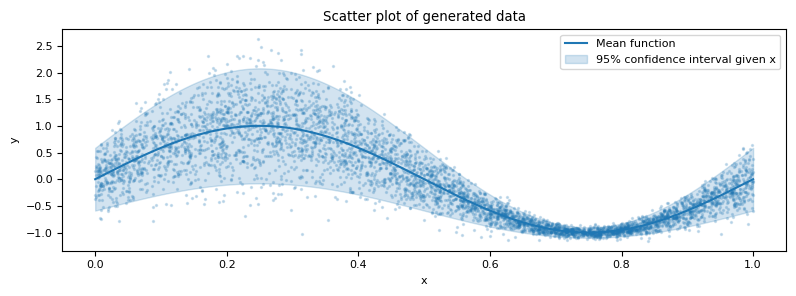

In [3]:
x_grid = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_grid, mean_function(x_grid), color="C0", label="Mean function")
ax.fill_between(
    x_grid,
    mean_function(x_grid) - 1.96 * deviation_function(x_grid),
    mean_function(x_grid) + 1.96 * deviation_function(x_grid),
    color="C0",
    alpha=0.2,
    label="95% confidence interval given x",
)
ax.scatter(X, y, s=2, color="C0", alpha=0.2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Scatter plot of generated data")
ax.legend()
plt.tight_layout()

___

## Histograms

The task of density estimation may initially seem daunting, but in reality, it becomes quite intuitive once we recognize that a histogram (normalized to have an integral of 1) is effectively a technique aimed at achieving this objective. By counting the number of examples in each bin, we discretize the distribution, enabling us to estimate the probability of the regions and thus obtain a "low-resolution" density estimation.

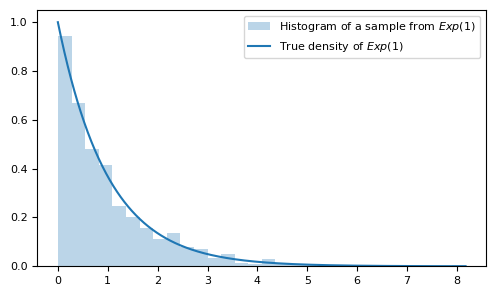

In [4]:
from scipy.stats import expon

hist_sample_example = np.random.RandomState(42).exponential(size=1000)
hist_linspace_example = np.linspace(0, max(hist_sample_example), 1000)

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(
    hist_sample_example,
    bins=30,
    density=True,
    color="C0",
    alpha=0.3,
    label="Histogram of a sample from $Exp(1)$",
)
ax.plot(
    hist_linspace_example,
    expon().pdf(hist_linspace_example),
    c="C0",
    label="True density of $Exp(1)$",
)
ax.legend()
plt.tight_layout()

However, employing all samples only yields a density estimate of $Y$ without imposing any condition on $X$.

We can easily condition this strategy on $X=x$ by only including points in proximity to $X=x$ when generating the histogram that will represent the conditional density. The definition of "proximity" can be flexible. For instance, we could use a strategy like [`sklearn.neighbors.NearestNeighbors.radius_neighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.radius_neighbors), which selects only the examples that reside within a radius of $\varepsilon$ from point $x$, or we could select a fixed number of nearest neighbors using a method like [`sklearn.neighbors.NearestNeighbors.kneighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors).

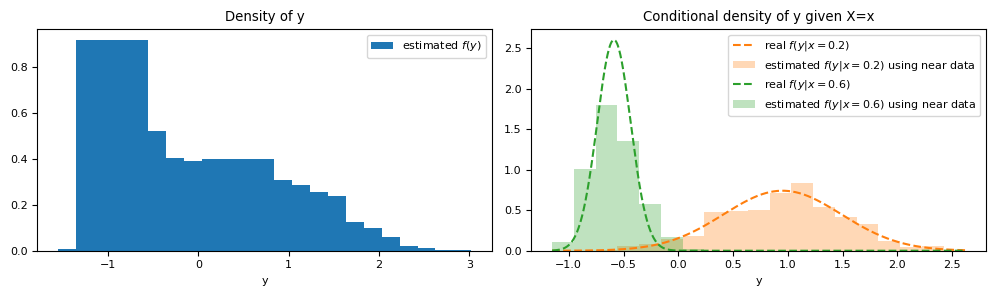

In [5]:
from scipy.stats import rv_histogram, norm

hist = np.histogram(y, bins=np.linspace(-1.5, 3, 51))
hist_dist = rv_histogram(hist)

def plot_conditional_y_using_near_data(ax, x_value, X, y, c, eps=0.05):
    ax.plot(
        y_grid_refined,
        norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(
            y_grid_refined
        ),
        "--",
        color=c,
        label=f"real $f(y | x = {x_value})$",
    )
    ax.hist(
        y[(X < x_value + eps) & (X > x_value - eps)],
        alpha=0.3,
        bins=y_grid,
        density=True,
        color=c,
        label=f"estimated $f(y | x = {x_value})$ using near data",
    )

min_y, max_y = min(y), max(y)
y_grid = np.linspace(min_y, max_y, 20)
y_grid_refined = np.linspace(min_y, max_y, 1000)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].bar(y_grid, hist_dist.pdf(y_grid), label="estimated $f(y)$")
ax[0].set_title("Density of y")
ax[0].set_xlabel("y")
ax[0].legend()

plot_conditional_y_using_near_data(ax=ax[1], x_value=0.2, X=X, y=y, c="C1")
plot_conditional_y_using_near_data(ax=ax[1], x_value=0.6, X=X, y=y, c="C2")
ax[1].set_title("Conditional density of y given X=x")
ax[1].set_xlabel("y")
ax[1].legend()
plt.tight_layout()

___

## Kernel Density Estimation

While histograms serve as excellent baselines, they can pose challenges for more intricate distributions. Determining the appropriate number of bins can prove difficult, and we may end up with stair-step functions that aren't the most manageable to work with.

In general, the problem of non-parametric density estimation is frequently tackled using Kernel Density Estimation (KDE), and it is logical to use it here too, aligning it with a strategy to convert the problem into a conditional estimation. The essential concept of KDE is to place "bumps" around observed points (shaped like a Gaussian, for instance) and then sum these bumps, normalizing them to yield a density estimate.

$\oint$ _The nature of the bump (which is called a kernel) and the width (bandwidth) of these bumps are hyperparameters that can be tuned using cross-validation with a likelihood-style metric to assess the likelihood of a test sample having been drawn from your estimated density [[2](#bibliography)]._

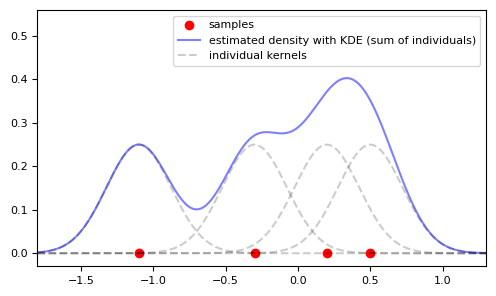

In [6]:
def gaussian_kernel(x, y):
    return np.exp(-((x - y) ** 2) / 0.1)

def kde(x, S):
    return sum(gaussian_kernel(x, s) for s in S)

S = [-1.1, -0.3, 0.2, 0.5]
grid_kde = np.linspace(-1.8, 1.3, 1000)

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(S, [0] * len(S), c="r")
ax.plot(grid_kde, kde(grid_kde, S) / len(S), c="b", alpha=0.5)
for s in S:
    ax.plot(grid_kde, gaussian_kernel(grid_kde, s) / len(S), "--", c="k", alpha=0.2)
ax.set_ylim(-0.03, 0.56)
ax.set_xlim(-1.8, 1.3)
ax.legend(
    ["samples", "estimated density with KDE (sum of individuals)", "individual kernels"]
)
plt.tight_layout()

To condition our KDE, we can once again use a neighbor search. Utilizing [`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) and [`sklearn.neighbors.KernelDensity`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) (without being overly concerned about this model's hyperparameters), we can identify the neighbors closest to a specific point, say $X=0.2$, and then estimate the density using these neighbors.

In [7]:
from sklearn.neighbors import NearestNeighbors, KernelDensity

x_value = 0.2
knn = NearestNeighbors(n_neighbors=100).fit(X.reshape(-1, 1))
_, ind_x_value = knn.kneighbors([[x_value]])

kde = KernelDensity(kernel="gaussian", bandwidth="scott").fit(
    y[ind_x_value].reshape(-1, 1)
)

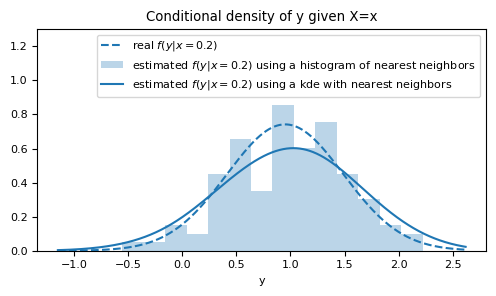

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(
    y_grid_refined,
    norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(
        y_grid_refined
    ),
    "--",
    color="C0",
    label=f"real $f(y | x = {x_value})$",
)
ax.hist(
    y[ind_x_value].ravel(),
    alpha=0.3,
    bins=y_grid,
    density=True,
    color="C0",
    label=f"estimated $f(y | x = {x_value})$ using a histogram of nearest neighbors",
)
ax.plot(
    y_grid_refined,
    np.exp(kde.score_samples(y_grid_refined.reshape(-1, 1))),
    color="C0",
    label=f"estimated $f(y | x = {x_value})$ using a kde with nearest neighbors",
)
ax.set_title("Conditional density of y given X=x")
ax.set_xlabel("y")
ax.set_ylim(0, 1.3)
ax.legend()
plt.tight_layout()

Notice that this method provides a much smoother estimate compared to the histogram.

We can encapsulate this logic within a class that tries to follow the [scikit-learn API](https://scikit-learn.org/stable/developers/develop.html), so that the `.predict` method applies the aforementioned logic for each requested value. In other words, it initially searches for the neighbors, and then employs a KDE to obtain the estimates for each example.

In [9]:
from sklearn.base import BaseEstimator, clone

class ConditionalNearestNeighborsKDE(BaseEstimator):
    """Conditional Kernel Density Estimation using nearest neighbors.

    This class implements a Conditional Kernel Density Estimation by applying
    the Kernel Density Estimation algorithm after a nearest neighbors search.

    It allows the use of user-specified nearest neighbor and kernel density
    estimators or, if not provided, defaults will be used.

    Parameters
    ----------
    nn_estimator : NearestNeighbors instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.NearestNeighbors` class
    to use for finding nearest neighbors. If not specified, a
    `~sklearn.neighbors.NearestNeighbors` instance with `n_neighbors=100`
    will be used.

    kde_estimator : KernelDensity instance, default=None
    A pre-configured instance of a `~sklearn.neighbors.KernelDensity` class
    to use for estimating the kernel density. If not specified, a
    `~sklearn.neighbors.KernelDensity` instance with `bandwidth="scott"`
    will be used.
    """

    def __init__(self, nn_estimator=None, kde_estimator=None):
        self.nn_estimator = nn_estimator
        self.kde_estimator = kde_estimator

    def fit(self, X, y=None):
        if self.nn_estimator is None:
            self.nn_estimator_ = NearestNeighbors(n_neighbors=100)
        else:
            self.nn_estimator_ = clone(self.nn_estimator)
        self.nn_estimator_.fit(X, y)
        self.y_train_ = y
        return self

    def predict(self, X):
        """Predict the conditional density estimation of new samples.

        The predicted density of the target for each sample in X is returned.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Vector to be estimated, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        kernel_density_list : list of len n_samples of KernelDensity instances
            Estimated conditional density estimations in the form of
            `~sklearn.neighbors.KernelDensity` instances.
        """
        _, ind_X = self.nn_estimator_.kneighbors(X)
        if self.kde_estimator is None:
            kernel_density_list = [
                KernelDensity(bandwidth="scott").fit(self.y_train_[ind].reshape(-1, 1))
                for ind in ind_X
            ]
        else:
            kernel_density_list = [
                clone(self.kde_estimator).fit(self.y_train_[ind].reshape(-1, 1))
                for ind in ind_X
            ]
        return kernel_density_list

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

ckde = ConditionalNearestNeighborsKDE().fit(X_train.reshape(-1, 1), y_train)
ckde_preds = ckde.predict(X_test.reshape(-1, 1))

___

## Evaluation metrics for conditional density estimation methods

Clearly, applying traditional regression metrics directly here can be challenging, necessitating an approach specific to the problem we're addressing. This discussion is a bit more involved, but it's critical for evaluating our estimators.

$\oint$ _Certain metrics from conformal prediction could be utilized here, like "how often the observed target falls within a confidence interval", if you construct confidence intervals from the estimated conditional densities. However, metrics inherently suited to the nature of the problem are more suitable._

Let's denote the true conditional probability density of the problem as $f(y \,|\, X=x)$, and the estimated density as $\hat{f}(y \,|\, X=x)$. We want to gauge how close these two functions are, even though we don't have $f(y | x)$. A smart way to handle this is to compute the mean square error of the difference [[3](#bibliography)]

$$ L(f, \hat{f}) = \mathbb{E}_X\left( \int \left( \hat{f}(y \,|\, X) - f(y \,|\, X) \right)^2 dy \right) = \int \int \left( \hat{f}(y \,|\, X=x) - f(y \,|\, X=x) \right)^2  dy \, f(x) \, dx.$$

$\oint$ <em>This metric differs somewhat from the mean square error as empirical risk for our point estimates $h(x)$. When we calculate $\frac{1}{n} \sum_{i=1}^n \left( h(x_i) - y_i \right)$, we're effectively estimating</em>

$$\mathbb{E}_{(X, Y)}\left( h(X) - Y \right) = \int \int \left( h(x) - y \right)^2 f(x,y) \, dx \, dy.$$

<em>In the metric $L$, we average only with respect to $X$, so that, for a fixed $X=x$, we want $\hat{f}(y \,|\, X=x)$ to approximate $f(y \,|\, X=x)$ well for all possible $y$ values uniformly in $\mathbb{R}$.</em>

Upon expanding $L$, we obtain

$$ L(f, \hat{f}) = \int \int \left( \hat{f}(y \,|\, X=x) \right)^2 f(x) \, dy \, dx + \int \int -2\hat{f}(y \,|\, X=x) f(y, x) dx dy + C,$$

where $f(x,y) = f(y \,|\, x) f(x)$ and $C$ is defined as $C = \int \int \left( f(y \,|\, x) \right)^2 f(x) \, dy \, dx$. As $C$ is a constant independent of the estimation method of $\hat{f}$, it can be disregarded when comparing models.

The first term can be written as

$$ \int \left( \int \left( \hat{f}(y \,|\, X=x) \right)^2\, dy \right) f(x)  \, dx, $$

and the interior integral can be calculated using a numerical integration method while the x-integral can be estimated using an empirical average in a validation sample $S=(x_i, y_i)_{i=1}^n$. Specifically, we have

$$ \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right). $$

The second term can be directly estimated as the empirical average

$$ \frac{-2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i), $$

also using $S$.

Our estimates enable us to calculate a model comparison metric given by

$$ L(f, \hat{f}) \approx \hat{L}(f, \hat{f}, S) = \frac{1}{n} \sum_{i=1}^n \left( \int  \left( \hat{f}(y \,|\, X=x_i) \right)^2 \, dy \right) - \frac{2}{n} \sum_{i=1}^n \hat{f}(y_i \,|\, X=x_i),$$

where a good model should yield as small a value as possible [[3](#bibliography)].

$\oint$ _It's intriguing to casually interpret this final expression we obtained. As we aim to minimize $\hat{L}(f, \hat{f}, S)$, we want the integrals of the conditional densities squared to be small, while the likelihoods of the observed samples are large (rendering the second term highly negative). That is, we desire our function to be well-behaved and not explode, while we want the observed points to have a high likelihood of being sampled according to our prediction._

We can implement this in a way that it accepts pre-calculated density estimates and performs the necessary operations (both integration and summation). For the integral, we're explicitly asking for a `y_grid` where it will be estimated using [`sklearn.metrics.auc`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html).

In [11]:
from sklearn.metrics import auc, make_scorer
from joblib import Parallel, delayed

def squared_loss(y_true, cde_preds, y_grid, n_jobs=-1):
    """
    Average squared loss between the true conditional density and predicted one.

    This method can be used to assess the quality of the conditional probability
    density function fit.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        The true values of y for each sample.

    cde_preds : list of len n_samples of KernelDensity instances
        The predicted conditional densitys. Each instance should be a fitted
        KernelDensity instance.

    y_grid : array-like of shape (n_samples,)
        The grid of y values used for computing the area under the curve (AUC)
        for the squared PDF.

    n_jobs : int, optional
        The number of jobs to run in parallel. '-1' means using all processors.

    Returns
    -------
    average_squared_loss: float
        The average squared loss between the true and predicted conditional
        probability density functions. Note that it is always off by C.
    """

    def _compute_individual_loss(y_, cde_pred):
        # The score_samples and score methods returns stuff on log scale,
        # so we have to exp it.
        squared_auc = auc(
            y_grid, np.exp(cde_pred.score_samples(y_grid.reshape(-1, 1))) ** 2
        )
        expected_value = np.exp(cde_pred.score([[y_]]))
        return squared_auc - 2 * expected_value

    individual_squared_loss = Parallel(n_jobs=n_jobs)(
        delayed(_compute_individual_loss)(y_, cde_pred)
        for y_, cde_pred in zip(y_true, cde_preds)
    )

    average_squared_loss = sum(individual_squared_loss) / len(y_true)
    return average_squared_loss

Applying this to the previous data provides us with a method to quantify our performance in CDE.

In [12]:
squared_loss(y_test, ckde_preds, np.linspace(-5, 5, 1000))

-0.837595643080642

For the sake of comparison, we could contrast it with the density estimation of $Y$ without considering conditionality, that is, training the KDE on all the training data.

In [13]:
squared_loss(
    y_test,
    len(y_test) * [KernelDensity(bandwidth="scott").fit(y_train.reshape(-1, 1))],
    np.linspace(-5, 5, 1000),
)

-0.38725117712967094

Since the previous value is lower, we can conclude that it provides a better density estimation, as anticipated.

$\oint$ _While this metric is useful for comparing models, it might be difficult to interpret from a business perspective. In this case, it might be helpful to convert your distribution forecast into a point forecast to calculate a more traditional metric, such as [`sklearn.metrics.mean_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (or even conformal prediction metrics), to provide a more digestible interpretation._

With a method to compare models in place, it's natural to want to optimize hyperparameters using a tool like [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Given that we've designed the `ConditionalNearestNeighborsKDE` to comply with the [scikit-learn standard](https://scikit-learn.org/stable/developers/develop.html), and the metric in a way that it accepts the output from a `.predict` method, we can readily employ [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to optimize our usage of [`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html).

In [14]:
from functools import partial
from sklearn.model_selection import GridSearchCV

squared_loss_score = make_scorer(
    partial(squared_loss, y_grid=np.linspace(-5, 5, 1000)), greater_is_better=False
)
param_grid = {
    "nn_estimator": [
        NearestNeighbors(n_neighbors=n_neighbors) for n_neighbors in [100, 500, 1000]
    ],
}
gs = GridSearchCV(
    ConditionalNearestNeighborsKDE(), param_grid=param_grid, scoring=squared_loss_score
).fit(X_train.reshape(-1, 1), y_train)

(
    pd.DataFrame(gs.cv_results_)
    .filter(
        ["param_nn_estimator", "mean_score_time", "mean_test_score", "std_test_score"]
    )
    .sort_values(by="mean_test_score", ascending=False)
    .reset_index(drop=True)
)

,param_nn_estimator,mean_score_time,mean_test_score,std_test_score
0,NearestNeighbors(n_neighbors=500),3.838123,0.890078,0.021875
1,NearestNeighbors(n_neighbors=100),1.243606,0.859500,0.016847
2,NearestNeighbors(n_neighbors=1000),6.416354,0.711722,0.018199


In [15]:
squared_loss(
    y_test, gs.best_estimator_.predict(X_test.reshape(-1, 1)), np.linspace(-5, 5, 1000)
)

-0.9058110146877884

In this case, we achieve a better score than before using any value of neighbors. However, we could still be interested in aspects of kernel estimation, which could further enhance the result.

The `ConditionalNearestNeighborsKDE` structure was proposed as it is more intuitive. Nonetheless, in higher dimensions or in scenarios with a lot of data, the neighbor search can encounter certain issues. Firstly, it's computationally costly due to the requirement for distance comparisons. Secondly, we might easily be at the mercy of varying scales of variables, potentially including categorical variables. Thirdly, we might have many less informative variables in $X$ and consequently suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), with our neighbors becoming increasingly distant and less representative. In a real-world problem, you might have hundreds of covariates you wish to condition on and millions of examples, making this strategy possibly less suitable.

___

## LeafNeighbors

A potential way to bypass the complications posed by neighbor searches in high dimensions, such as irrelevant variables, and varied scales and types is to formulate a more suitable distance metric robust to these challenges.

The manner in which tree training is conducted naturally equips it to tackle these issues effectively because: tree models learn what the important features are through the process of choosing the best splits; and they are not concerned about the scale of variables, as they focus only on the ordering during training.

When training a bagging of trees, we see variability in splits across the feature space, enabling us to use co-occurrence in the same leaves as a measure of similarity between examples [[4](#bibliography)].

Hence, if we train a bagging model of regression trees like [`sklearn.ensemble.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [`sklearn.ensemble.ExtraTreesRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) to predict $Y$ from $X$, we are inherently constructing trees that create splits in relevant variables for predicting $Y$. At the same time, we disregard different scales by considering all instances that occur in the same leaf as similar, achieved by counting the co-occurrences of leaves across different models in the bagging [[5](#bibliography)].

We can design a neighbor search class following this rationale, in accordance with the [scikit-learn standards](https://scikit-learn.org/stable/developers/develop.html).

In [16]:
from sklearn.neighbors._base import NeighborsBase
from sklearn.ensemble import RandomForestRegressor

class LeafNeighbors(NeighborsBase):
    """Neighbors search using leaf nodes coincidence in a tree ensemble as a
    similarity measure.

    This class implements a supervised neighbor search using the leafs of an
    ensemble tree estimator as a measure of distance. Examples that occur
    simultaneously in several sheets are naturally close in variables relevant
    to the target.

    Parameters
    ----------
    tree_ensemble_estimator : ForestRegressor instance, default=None
        The ensemble tree estimator to use. If None, a
        `~sklearn.ensemble.RandomForestRegressor` with `max_depth=10` will be
        used.

    n_neighbors : int, default=5
        Number of neighbors to use in the neighbor-based learning method.

    random_state : int, RandomState instance or None, default=None
        Controls the randomness of the ensemble tree estimator. Pass an int
        for reproducible output across multiple function calls.
    """

    def __init__(self, tree_ensemble_estimator=None, n_neighbors=5, random_state=None):
        self.tree_ensemble_estimator = tree_ensemble_estimator
        self.n_neighbors = n_neighbors
        self.random_state = random_state

    def fit(self, X, y=None):
        if self.tree_ensemble_estimator is None:
            self.tree_ensemble_estimator = RandomForestRegressor(
                max_depth=10, random_state=self.random_state
            )
        else:
            self.tree_ensemble_estimator = clone(self.tree_ensemble_estimator)

        self.nn_estimator_ = NearestNeighbors(
            n_neighbors=self.n_neighbors, metric="hamming"
        )

        self.tree_ensemble_estimator.fit(X, y)
        leafs_X = self.tree_ensemble_estimator.apply(X)
        self.nn_estimator_.fit(leafs_X)
        return self

    def kneighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.kneighbors(leafs_X)

    def radius_neighbors(self, X):
        leafs_X = self.tree_ensemble_estimator.apply(X)
        return self.nn_estimator_.radius_neighbors(leafs_X)

And use it in the `ConditionalNearestNeighborsKDE`, defining the parameter `nn_estimator` with the custom search method.

In [17]:
crfkde = ConditionalNearestNeighborsKDE(
    nn_estimator=LeafNeighbors(n_neighbors=100)
).fit(X_train.reshape(-1, 1), y_train)
crfkde_preds = crfkde.predict(X_test.reshape(-1, 1))

squared_loss(y_test, crfkde_preds, np.linspace(-5, 5, 1000))

-0.8328820889563571

In this scenario, the metric ended up similar to the one employed in the previous problem with neighbors, as the dimensionality is low. Consequently, the neighbors identified along the line closely align with the conventional approach of searching for nearby neighbors with euclidean distance.

___

## FlexCode

FlexCode takes a fundamentally different approach to the CDE problem by employing arguments from linear algebra to estimate the conditional probability density function using a function basis.

The space of [square integrable functions](https://mathworld.wolfram.com/L2-Space.html) ($L^2(\mathbb{R})$) is a vector space equipped with an inner product defined as $\left\langle g, h\right\rangle = \int_{\mathbb{R}} g(t)\, h(t) \, dt$. Similar to finite-dimensional vector spaces, it possesses a (in this case, infinite) basis $\left\{ \phi_i \in L^2(\mathbb{R}) : i \in \mathbb{N}\right\}$, where any function $g \in L^2(\mathbb{R})$ can be expressed as a linear combination of the basis elements: $g(t) = \sum_{i=1}^\infty \beta_i \phi_i(t)$, for all $t \in \mathbb{R}$. Furthermore, it is possible to impose an orthonormal condition on the basis, such that $\left\langle \phi_i, \phi_j\right\rangle = \delta_{i,j}$, where $\delta_{i,j}$ equals $1$ if $i = j$ and $0$ otherwise [[3](#bibliography)]. To help illustrate this concept, if you are unfamiliar with it, consider the analogy to the application of [Fourier series](https://en.wikipedia.org/wiki/Fourier_series).

With any fixed orthonormal basis $\left\{ \phi_i \right\}$, it is possible to express the conditional probability density function as follows [[3](#bibliography)]:

$$f(y \,|\, X=x) = \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y),$$

In this formulation, we explicitly incorporate the dependence of $X=x$ within the coefficients of the linear combination.

It is worth noting that due to the orthonormality of the basis $\left\{ \phi_i \right\}$, we have the following property:

$$
\begin{align*}
    \mathbb{E}\left( \phi_j(Y) \,|\, X=x \right) &= \int_\mathbb{R} \phi_j(y) \,f(y \,|\, X=x) \,dy\\
    &= \int_\mathbb{R} \phi_j(y) \sum_{i=1}^\infty \beta_i(x)\, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \int_\mathbb{R} \phi_j(y) \, \phi_i(y) \,dy\\
    &= \sum_{i=1}^\infty \beta_i(x) \,\delta_{i,j} = \beta_j(x).
\end{align*}
$$

Hence, the estimation of $\hat{\beta}_j(x)$ can be achieved through regression, utilizing $X$ as predictors to estimate $\phi_j(Y)$.

The [FlexCode](https://pypi.org/project/flexcode/) algorithm [[3](#bibliography)] adopts this approach. By employing a designated `basis_system` (a hyperparameter of the model), the algorithm estimates the coefficients using regressions of $\phi_j(Y)$. Since computing the infinite sum is not practical, it is truncated at a specified value, `max_basis` denoted as $I$ (which can be determined through cross-validation as a hyperparameter). Consequently, we obtain the following expression:

$$ \hat{f}(y \,|\, X=x) = \sum_{i=1}^I \hat{\beta}_i(x) \, \phi(y).$$

___

## Using FlexCode in Python

To utilize FlexCode, we first need to define the regression model along with its parameters, as well as the previously mentioned hyperparameters.

In [18]:
from flexcode.regression_models import RandomForest
from flexcode import FlexCodeModel

flexcode_model = FlexCodeModel(
    RandomForest,
    basis_system="cosine",
    max_basis=31,
    regression_params={"max_depth": 5, "n_estimators": 100},
)
flexcode_model.fit(X_train, y_train)

As implemented, the estimator returns the value of $\hat{f}(y \,|\, X=x)$ on a grid of $y$ values.

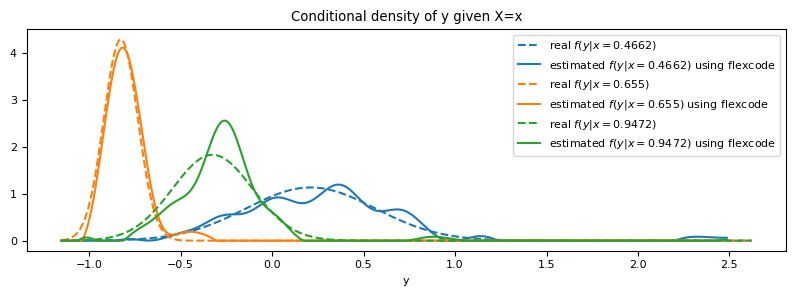

In [19]:
cdes, y_grid_flexcode = flexcode_model.predict(X_test, n_grid=400)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

fig, ax = plt.subplots(figsize=(8, 3))
for c, sample_index in enumerate(np.random.RandomState(13).choice(len(X_test), size=3)):
    x_value = np.round(X_test[sample_index], 4)
    ax.plot(
        y_grid_refined,
        norm(loc=mean_function(x_value), scale=deviation_function(x_value)).pdf(
            y_grid_refined
        ),
        "--",
        color=f"C{c}",
        label=f"real $f(y | x = {x_value})$",
    )
    ax.plot(
        y_grid_flexcode,
        cdes[sample_index],
        color=f"C{c}",
        label=f"estimated $f(y | x = {x_value})$ using flexcode",
    )
ax.set_title("Conditional density of y given X=x")
ax.set_xlabel("y")
ax.legend()
plt.tight_layout()

To evaluate the estimator, considering that we constructed our metric to work with an object similar to [`sklearn.neighbors.KernelDensity`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html), we need to ensure it has specific methods that we can implement, adapting the output of [`flexcode.FlexCodeModel`](https://github.com/lee-group-cmu/FlexCode) to match this format.

In [20]:
class FlexCode_return_to_DensityEstimator:
    def __init__(self, y_grid, pdf_values):
        self.y_grid = y_grid
        self.pdf_values = pdf_values
        self.density = rv_histogram(
            (pdf_values, np.hstack([y_grid, [y_grid[-1] + y_grid[-1] - y_grid[-2]]]))
        )

    def score_samples(self, X):
        return np.log(self.density.pdf(X))

    def score(self, X):
        return np.sum(self.score_samples(X))

density_estimation_preds_flexcode = [
    FlexCode_return_to_DensityEstimator(y_grid=y_grid_flexcode, pdf_values=cde)
    for cde in cdes
]
squared_loss(y_test, density_estimation_preds_flexcode, np.linspace(-5, 5, 1000))

-1.5436164449474372

In this scenario, the metric we obtained outperforms the KDE based on nearest neighbors that we used previously.

___

## Practical application

Let's apply these various techniques to a real regression problem, namely [`sklearn.datasets.fetch_california_housing`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html), to evaluate the performance of the different approaches discussed.

In [21]:
from sklearn.datasets import fetch_california_housing

X_california, y_california = fetch_california_housing(return_X_y=True)
(
    X_california_train,
    X_california_test,
    y_california_train,
    y_california_test,
) = train_test_split(X_california, y_california, test_size=0.33, random_state=42)
print(f"X dimension: {X_california.shape[1]}")

X dimension: 8


In [22]:
ckde_california = ConditionalNearestNeighborsKDE().fit(
    X_california_train, y_california_train
)
ckde_california_preds = ckde_california.predict(X_california_test)

squared_loss(y_california_test, ckde_california_preds, np.linspace(0, 6, 1000))

-0.2948159711962537

In [23]:
crfkde_california = ConditionalNearestNeighborsKDE(
    nn_estimator=LeafNeighbors(n_neighbors=100)
).fit(X_california_train, y_california_train)
crfkde_california_preds = crfkde_california.predict(X_california_test)

squared_loss(y_california_test, crfkde_california_preds, np.linspace(0, 6, 1000))

-0.6802084650191235

In [24]:
model_california = FlexCodeModel(
    RandomForest, max_basis=31, regression_params={"max_depth": 10, "n_estimators": 100}
)
model_california.fit(X_california_train, y_california_train)

cdes_california, y_grid_california = model_california.predict(
    X_california_test, n_grid=400
)
y_grid_california = y_grid_california.reshape(-1)
density_estimation_preds_flexcode_california = [
    FlexCode_return_to_DensityEstimator(y_grid=y_grid_california, pdf_values=cde)
    for cde in cdes_california
]

squared_loss(
    y_california_test,
    density_estimation_preds_flexcode_california,
    np.linspace(0, 6, 1000),
)

-1.2739272081741533

We can observe that the neighbor search using `LeafNeighbors` outperforms the conventional neighbor search in our `ConditionalNearestNeighborsKDE` method. However, the `flexcode.FlexCodeModel` yields even better results compared to both methods in this example.

___

## Final considerations

Delving deeper into regression problems, beyond simple point estimates, can be challenging. However, this approach provides a wealth of insightful information that can enhance your decision-making process. While it's a significant area of study, it has not yet become a primary focus within the community. Nonetheless, I anticipate a surge of interest as more individuals realize its value.

Currently, the libraries designed to address these intricate problems are being refined, with issues being resolved over time. Therefore, when utilizing these tools, it's essential to exercise caution and promptly report any anomalous behavior observed.

$\oint$ _I cared to mention the tree-based neighbor method because it is possible to adapt the tree training in a specific way for the CDE problems. Typically, in regression problems, a decision tree would aim to optimize a particular metric such as [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) when establishing its splits. However, for CDE problems, there's a possibility to optimize a CDE-specific metric directly within the splits. One such metric could be the CDE `squared_loss` we implemented earlier. This approach is what the [RFCDE (Random Forests for Conditional Density Estimation)](https://github.com/lee-group-cmu/RFCDE) method suggests [[6](#bibliography)]._

## <a name="bibliography">Bibliography</a>

[1] [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification. Anastasios N. Angelopoulos, Stephen Bates. 2021.](http://people.eecs.berkeley.edu/~angelopoulos/blog/posts/gentle-intro/)

[2] [Python Data Science Handbook: In-Depth Kernel Density Estimation. Jake VanderPlas. 2016.](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

[3] [Converting high-dimensional regression to high-dimensional conditional density estimation. Rafael Izbicki, Ann B. Lee. Electron. J. Statist. 2017.](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-11/issue-2/Converting-high-dimensional-regression-to-high-dimensional-conditional-density-estimation/10.1214/17-EJS1302.full)

[4] [Supervised clustering and forest embeddings. Guilherme Duarte Marmerola. 2018.](https://gdmarmerola.github.io/forest-embeddings/)

[5] [Quantile Regression Forests. Nicolai Meinshausen. Journal of Machine Learning Research. 2006.](https://jmlr.csail.mit.edu/papers/volume7/meinshausen06a/meinshausen06a.pdf)

[6] [RFCDE: Random Forests for Conditional Density Estimation. Taylor Pospisil, Ann B. Lee. 2018.](https://arxiv.org/abs/1804.05753)